# Plots for the presentation

In [1]:
import nest
import numpy as np
import pylab as pl
from sklearn.linear_model import LinearRegression
%matplotlib notebook
def compute_capacity(state_mat, signal):
    """
    Compute capacity to reconstruct y based on linearly combining a
    :param a: state matrix (NxT)
    :param y: target output (1xT)
    :return y_hat: estimated signal
    :return capacity: 
    :return error:
    """
    state_mat = state_mat.T
    signal_pred = LinearRegression(n_jobs=-1, fit_intercept=False, normalize=True, copy_X=False).fit(state_mat, signal).predict(state_mat)
    MSE_pred = np.mean((signal-signal_pred)**2)
    return signal_pred, 1. - (MSE_pred / np.var(signal)), MSE_pred

#from functions import *

# Global parameters
T = 1000  # total number of time steps
dt = 0.1  # simulation resolution

subsampling_factor=100 # select a subset of samples (1 = no timewise subsampling)

np.random.seed(42)
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,
    'print_time': True,
    'local_num_threads': 8})

###
# Input parameters
u_range = [0., 1.]
duration = 70. # [ms]

u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)
input_times = np.arange(dt, T*duration, duration)

###
# Parameters
nEnc = 1000
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(u)))
for n in range(nEnc):
	amplitudes[n, :] = u * tuning[n]
	nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
	nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
	                                     'amplitude_values': amplitudes[n]})
	nest.Connect([step_generator[n]], [enc_layer[n]])
    
enc_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt*subsampling_factor})
nest.Connect(enc_v, enc_layer)

In [2]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                   # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 1000                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# device
net_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt*subsampling_factor})
nest.Connect(net_v, neurons_e)

In [3]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

In [ ]:
nest.Simulate(T*duration+dt)

In [16]:
time_vector = np.arange(0., T*duration, dt) # take 1 sample per step
signal = np.zeros_like(time_vector)
for tt in range(len(input_times)-1):
	signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

ind_init = subsampling_factor*dt

if ind_init<1:
    ind_init = 0

inds_subsampling=np.arange(ind_init, len(signal)+ind_init,subsampling_factor,dtype=int)
signal=signal[inds_subsampling]
enc_activity = nest.GetStatus(enc_v)[0]['events']
net_activity = nest.GetStatus(net_v)[0]['events']

In [17]:
enc_indices = np.sort(np.unique(enc_activity['senders']))
enc_states = np.zeros((nEnc, int(T*duration/dt/subsampling_factor)))
for idx, i in enumerate(enc_indices):
    enc_states[idx, :] = enc_activity['V_m'][np.where(enc_activity['senders']==i)[0]]
    
net_indices = np.sort(np.unique(net_activity['senders']))
e_states = np.zeros((NE, int(T*duration/dt/subsampling_factor)))
for idx, i in enumerate(net_indices):
    e_states[idx, :] = net_activity['V_m'][np.where(net_activity['senders']==i)[0]]

### plot states

<IPython.core.display.Javascript object>


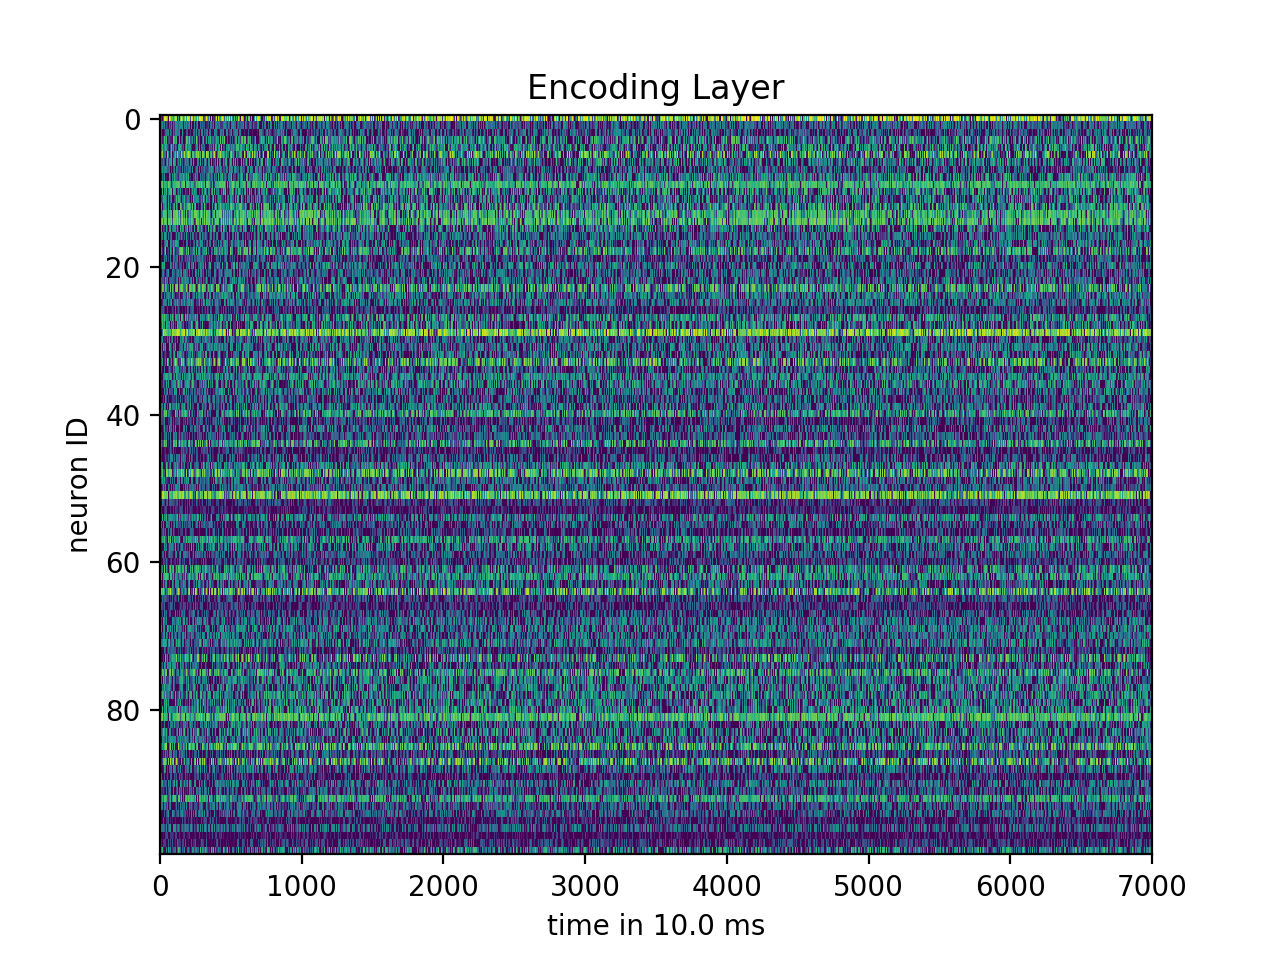

<IPython.core.display.Javascript object>


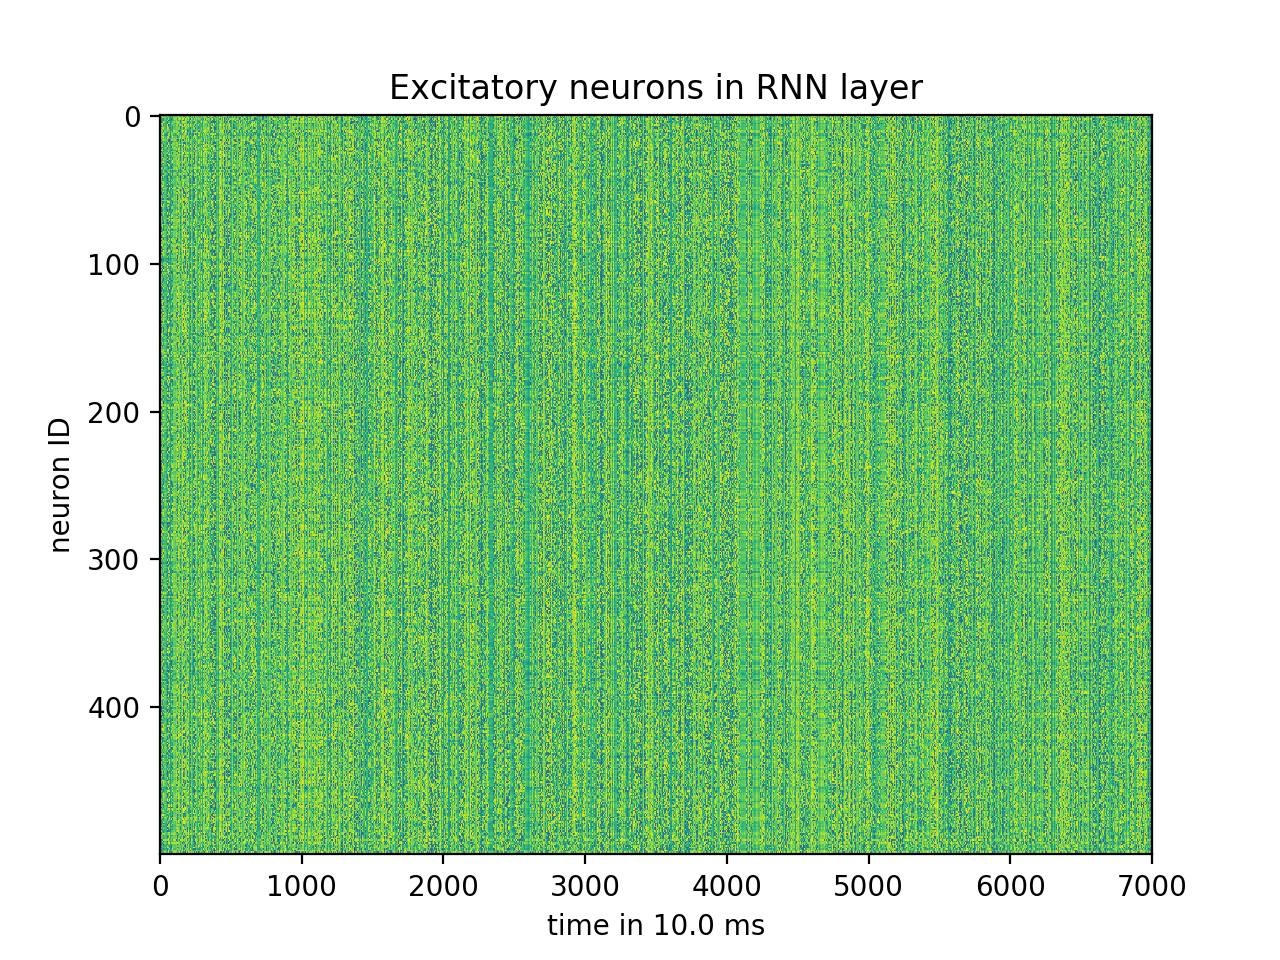

In [18]:
pl.figure()
pl.imshow(enc_states, aspect='auto')
pl.title("Encoding Layer")
pl.xlabel("time in {0} ms".format(str(dt*subsampling_factor)))
pl.ylabel("neuron ID")
pl.show()
pl.savefig("enc_states.png")
pl.figure()
pl.imshow(e_states, aspect='auto')
pl.title("Excitatory neurons in RNN layer")
pl.xlabel("time in {0} ms".format(str(dt*subsampling_factor)))
pl.ylabel("neuron ID")
pl.show()
pl.savefig("rnn_states.png")

In [8]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=0.622339831691564, MSE=0.026191033870218528
Main Circuit: 
	- Capacity=0.8084871968176024, MSE=0.013281565639281711


### Plot reconstructed signal

<IPython.core.display.Javascript object>


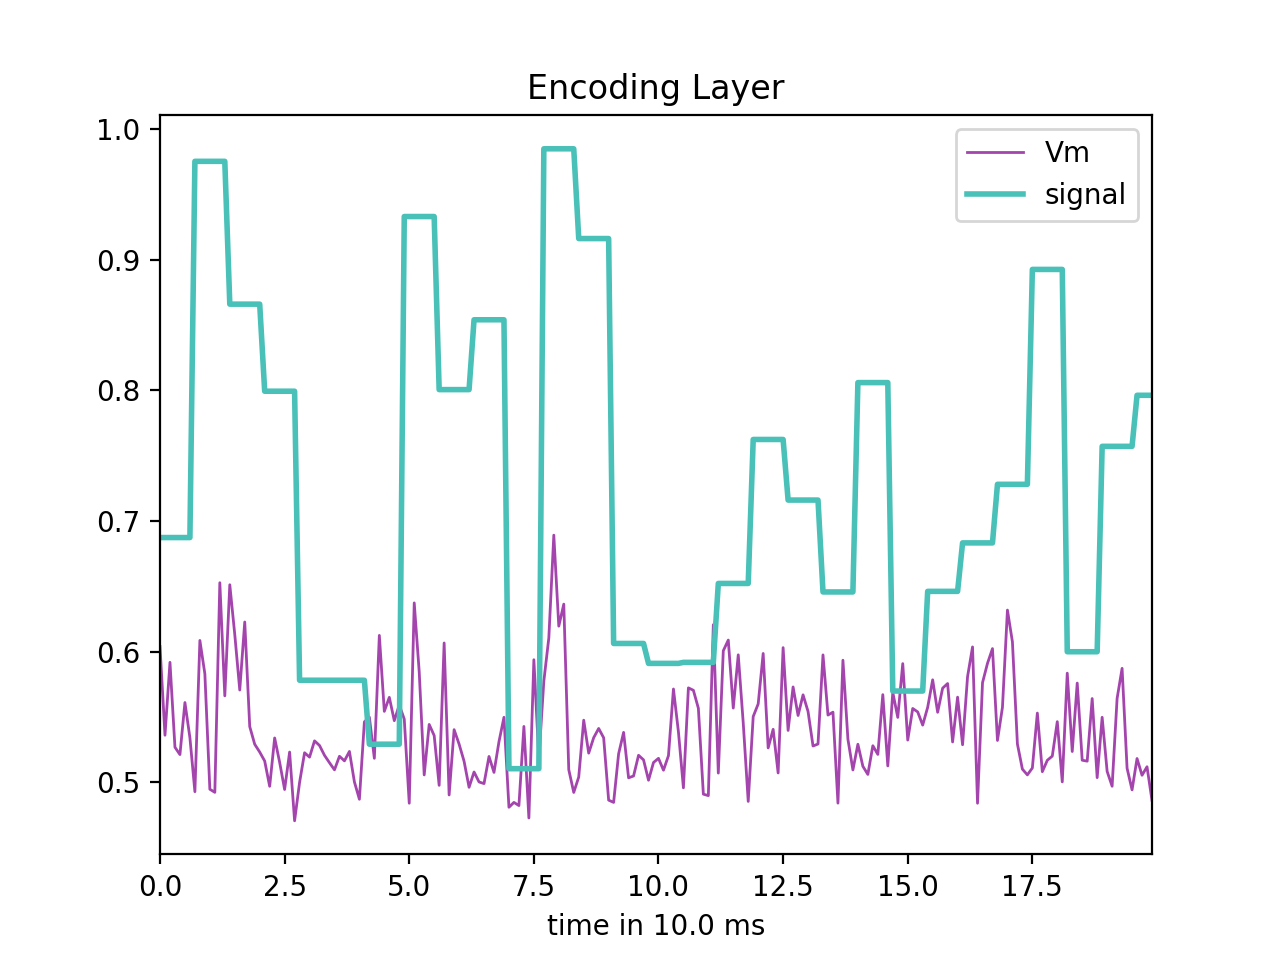

<IPython.core.display.Javascript object>


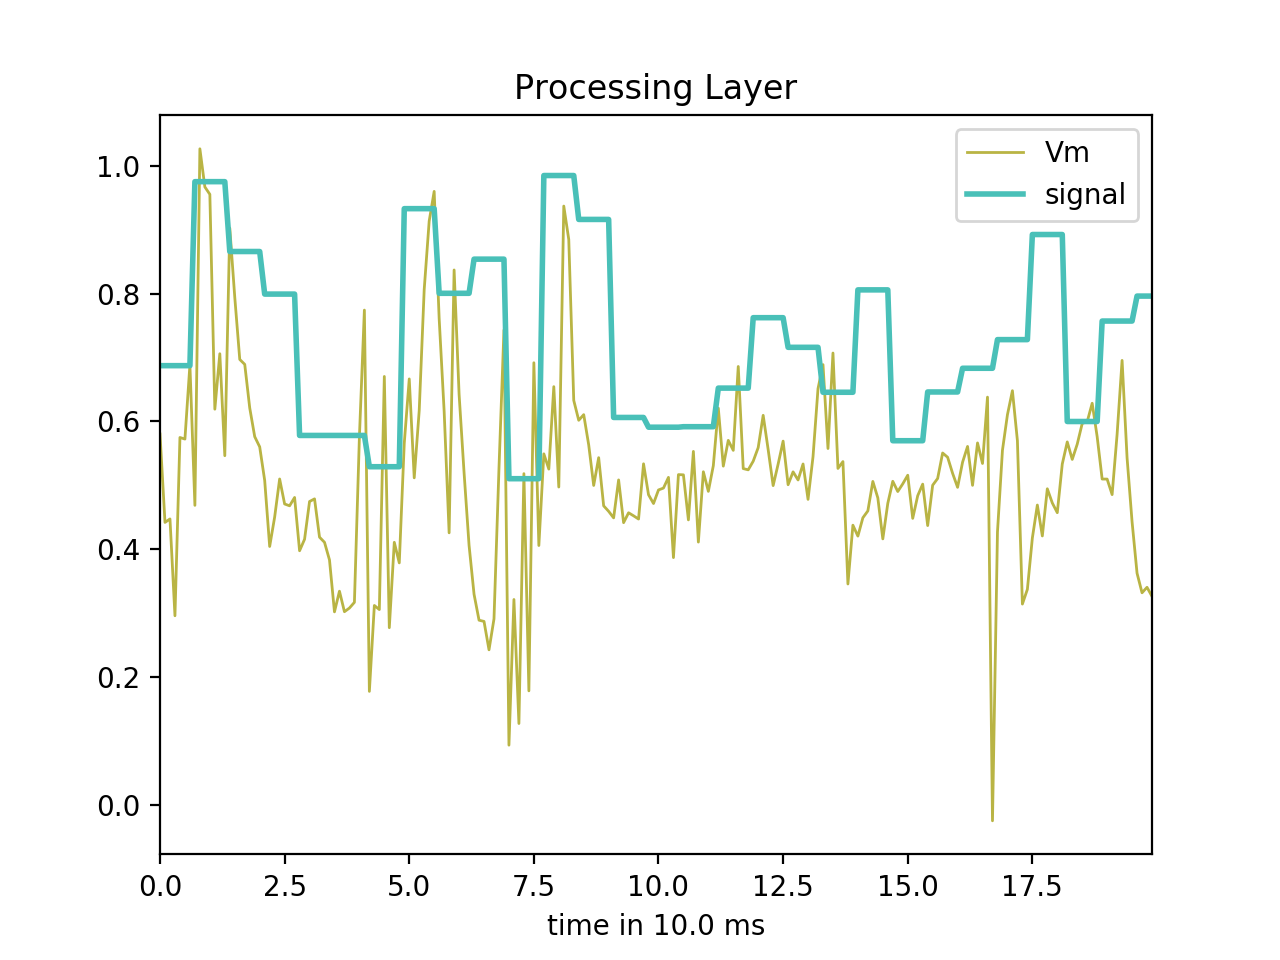

In [19]:
pl.figure()
time_sel=range(0,int(20001/subsampling_factor))
pl.plot(time_vector[time_sel], enc_estimate[time_sel], '#A444AD', linewidth=1)
pl.plot(time_vector[time_sel], signal[time_sel], '#49C0B8', linewidth=2)
pl.xlim([0., time_vector[time_sel[-1]]])
pl.title('Encoding Layer')
pl.xlabel("time in {0} ms".format(str(dt*subsampling_factor)))
pl.legend(("Vm", "signal"))
pl.show()
pl.savefig("enc_fit.png")
pl.figure()
pl.plot(time_vector[time_sel], circ_estimate[time_sel], '#B9B444', linewidth=1)
pl.plot(time_vector[time_sel], signal[time_sel], '#49C0B8', linewidth=2)
pl.xlim([0., time_vector[time_sel[-1]]])
pl.title('Processing Layer')
pl.xlabel("time in {0} ms".format(str(dt*subsampling_factor)))
pl.legend(("Vm", "signal"))
pl.show()
pl.savefig("rnn_fit.png")

In [10]:
max_lag = 100./(subsampling_factor)  # [ms] in this example
step_lag = 10./(subsampling_factor)   # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)
indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):
    
    # shift the target signal
    if idx > 0:
        shifted_signal = signal[:-idx]
    else:
        shifted_signal = signal
    
    # shift the population states
    enc_st = enc_states[:, idx:]
    circ_st = e_states[:, idx:]
    
    # compute capacity
    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
    circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag*subsampling_factor)))
    print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
    print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))
    
    encoder_capacity.append(enc_capacity)
    circuit_capacity.append(circ_capacity)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.622339831691564, MSE=0.026191033870218528
Main Circuit: 
	- Capacity=0.8084871968176024, MSE=0.013281565639281711
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.5123722811028142, MSE=0.03380182903206216
Main Circuit: 
	- Capacity=0.8389748372142602, MSE=0.011162091102313181
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.4002675390634912, MSE=0.04155368126353308
Main Circuit: 
	- Capacity=0.7447857032996958, MSE=0.017683040738566795
Lag = 30.000000000000004 ms
Encoding Layer: 
	- Capacity=0.28416945427747364, MSE=0.04957492695512963
Main Circuit: 
	- Capacity=0.62284293138747, MSE=0.026120056260248797
Lag = 40.0 ms
Encoding Layer: 
	- Capacity=0.1867917297631958, MSE=0.05629286168282541
Main Circuit: 
	- Capacity=0.4742059320669346, MSE=0.03639713689973561
Lag = 50.0 ms
Encoding Layer: 
	- Capacity=0.1112053138169804, MSE=0.06149679018462268
Main Circuit: 
	- Capacity=0.32467460821844263, MSE=0.04672658890783092
Lag = 60.00000000000001 ms
Encoding

### Plot total capacity

<IPython.core.display.Javascript object>


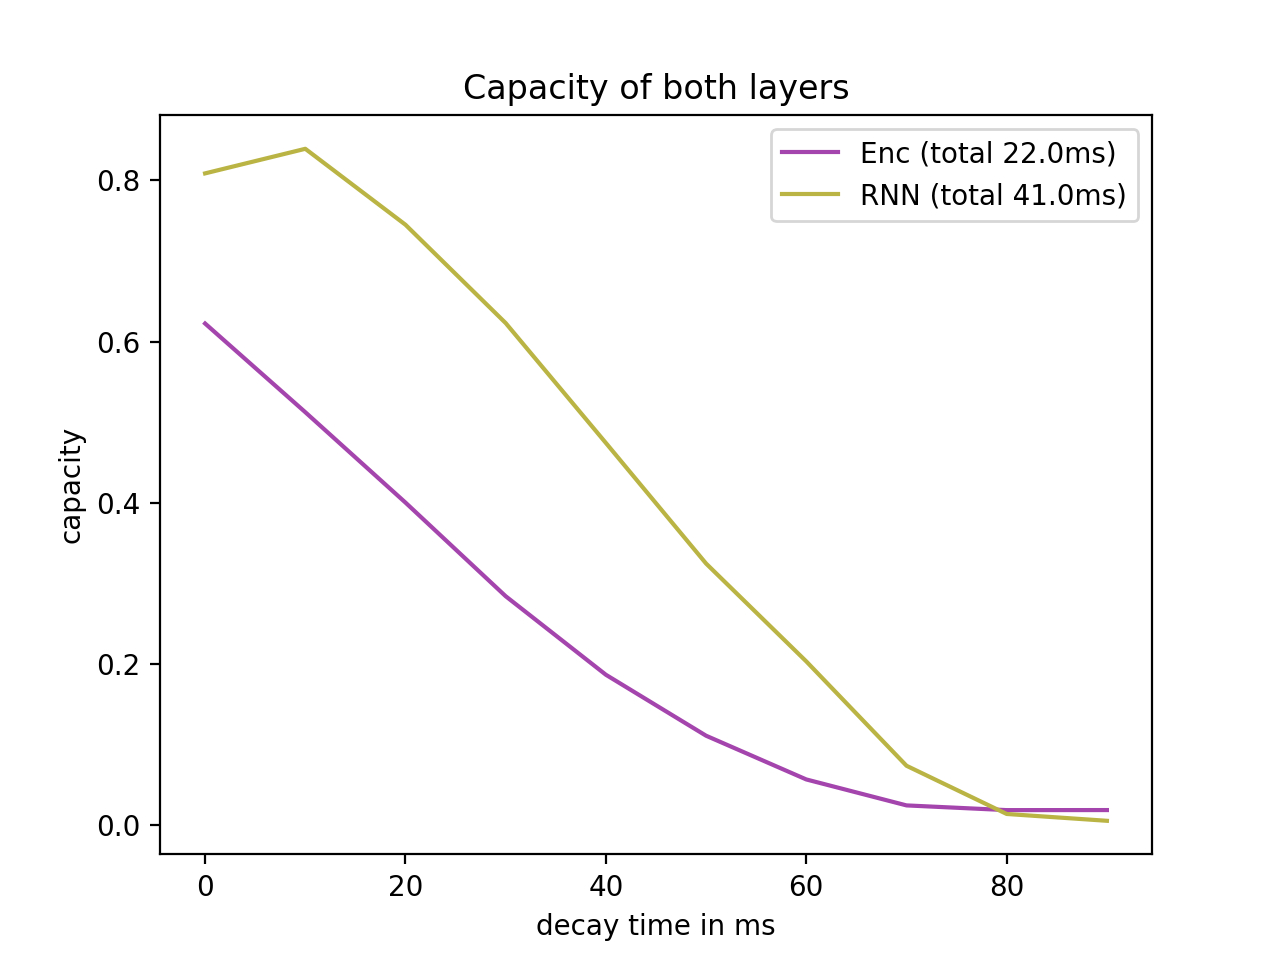

Total capacity (encoder): 0.22369462363050482 ms
Total capacity (processor): 0.4111173883510542 ms


In [20]:
tot_cap_enc = round(np.sum(encoder_capacity*subsampling_factor)*step_lag)
tot_cap_rnn = round(np.sum(circuit_capacity*subsampling_factor)*step_lag)

fig = pl.figure()
pl.plot(time_lags*subsampling_factor, encoder_capacity,'#A444AD')
pl.plot(time_lags*subsampling_factor, circuit_capacity,'#B9B444')
pl.legend(("Enc (total {0}ms)".format(str(tot_cap_enc)), "RNN (total {0}ms)".format(str(tot_cap_rnn))))
pl.ylabel("capacity")
pl.xlabel("decay time in ms")
pl.title("Capacity of both layers")
pl.show()
pl.savefig("capacity.png")
print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))